# Analysis of COVID-19 expression across disease conditions (robustness of SiFT kernels)

Application of `SiFT` on COVID-19 immune landscape depicted using data collected by Stephenson et al. (2021) [[1]](https://doi.org/10.1038/s41591-021-01329-2). Here we test robustness to `SiFT` kernel choice.


[[1] Stephenson, E., Reynolds, G., Botting, R. A., Calero-Nieto, F. J., Morgan, M. D., Tuong, Z. K., ... & Haniffa, M. (2021). Single-cell multi-omics analysis of the immune response in COVID-19. Nature medicine, 27(5), 904-916.](https://doi.org/10.1038/s41591-021-01329-2)

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import scanpy as sc

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


from scipy.stats import mannwhitneyu
from sklearn.preprocessing import normalize

import re
import sift

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [3]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

## Helper functions

In [4]:
def mannwhitneyu_test(adata, score_key="IFN_score"):
    """
    one-tail test
    """
    result = []
    for _celltype in adata.obs["cell_type"].cat.categories:
        exp_group = adata[adata.obs["cell_type"] == _celltype].obs[score_key]
        ctrl_group = adata[adata.obs["cell_type"] != _celltype].obs[score_key]
        
        _, _pval1 = mannwhitneyu(exp_group, 
                                 ctrl_group,
                                alternative="greater")
        result.append([_celltype, _pval1])
    PVAL_df = pd.DataFrame(result, columns=['cell_type', 'pvalue'])
    
    return PVAL_df

In [5]:
# pre-processing adapted from the analysis done in the original publication
def process_adata(
    adata, 
    n_neighbors=10, 
    use_rep = "X_pca",
    n_pcs=30, 
    hvg=True,
    n_top_genes = 2000,
    scale=True,
    graph=False,
    resolution=1,
):
    for key_ in ["X_pca_harmony", "X_pca", "X_umap"]:
        if key_ in adata.obsm:
            del adata.obsm[key_] 
    for key_ in ["leiden", "neighbors", "pca", "umap"]:
        if key_ in adata.uns:
            del adata.uns[key_]
    
    adata.raw = adata  
    if hvg:
        print("hvg")
        if "hvg" in adata.uns:
            del adata.uns["hvg"]
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=3000,
            subset=True,
            layer="counts",
            flavor="seurat_v3",
        )
    if scale:    
        print("scale")
        sc.pp.scale(adata, max_value=10)
    
    print("pca")
    sc.tl.pca(adata, svd_solver="arpack")
    
    if use_rep == "X_pca_harmony":
        print("pca_harmony")
        sc.external.pp.harmony_integrate(adata, "sample_id", basis="X_pca", adjusted_basis="X_pca_harmony")
        
    print("nns")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep=use_rep, n_pcs=n_pcs)
    
    print("umap")
    sc.tl.umap(adata)

    print("leiden")
    sc.tl.leiden(adata, resolution = resolution)
    
    if graph: 
        print("graph")
        sc.tl.draw_graph(adata, layout='fa')

## Set Parameters


In [6]:
DATA_DIR = str(DATA_DIR) + "/healthdisease_covid19/"
FIG_DIR = str(FIG_DIR) + "/healthdisease_covid19/"

In [7]:
import seaborn as sns
fontsize = 25
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = fontsize-4
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = fontsize-4
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = fontsize+4
plt.rcParams['legend.handlelength'] = 1.4 
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

sns.set(rc={"figure.dpi":300, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 2, 
                            "legend.frameon":"True"})

<ipython-input-7-d61a678d3ef3>:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [8]:
#https://www.gsea-msigdb.org/gsea/msigdb/cards/GOBP_RESPONSE_TO_TYPE_I_INTERFERON
IFN_genes = ["ABCE1","ADAR","BST2","CACTIN","CDC37","CNOT7","DCST1","EGR1","FADD","GBP2","HLA-A","HLA-B","HLA-C","HLA-E","HLA-F","HLA-G","HLA-H","HSP90AB1","IFI27","IFI35","IFI6","IFIT1","IFIT2","IFIT3","IFITM1","IFITM2","IFITM3","IFNA1","IFNA10","IFNA13","IFNA14","IFNA16","IFNA17","IFNA2","IFNA21","IFNA4","IFNA5","IFNA6","IFNA7","IFNA8","IFNAR1","IFNAR2","IFNB1","IKBKE","IP6K2","IRAK1","IRF1","IRF2","IRF3","IRF4","IRF5","IRF6","IRF7","IRF8","IRF9","ISG15","ISG20","JAK1","LSM14A","MAVS","METTL3","MIR21","MMP12","MUL1","MX1","MX2","MYD88","NLRC5","OAS1","OAS2","OAS3","OASL","PSMB8","PTPN1","PTPN11","PTPN2","PTPN6","RNASEL","RSAD2","SAMHD1","SETD2","SHFL","SHMT2","SP100","STAT1","STAT2","TBK1","TREX1","TRIM56","TRIM6","TTLL12","TYK2","UBE2K","USP18","WNT5A","XAF1","YTHDF2","YTHDF3","ZBP1"]

## Load processed data

In [ ]:
adata = sc.read(DATA_DIR +"haniffa21.hvg.h5ad")

## Apply `SiFT` - distance

In [ ]:
adata = adata[adata.obs["Status_on_day_collection_summary"].isin([
    "Asymptomatic", 
    "Critical",
    "Mild",
    "Moderate",
    "Severe", 
    "Healthy"]), :].copy()
adata.obsm["X_pca_harmony_norm"] = normalize(adata.obsm["X_pca_harmony"], axis=1)
adata = adata[adata.obs["Status_on_day_collection_summary"].argsort(), :]

In [ ]:
metric = "rbf"

Filter the healthy signal

In [ ]:
adata_sift = sift.sifter(
    adata=adata,
    kernel_key="X_pca_harmony_norm",
    metric=metric,
    embedding_key="X",
    src_key = "disease",
    tgt_key = "control", 
    kernel_params={"length_scale": 0.1},
    use_tgt=True,
    pseudocount=False,
    copy=True
)
    

## Save results

keep only the clinical samples

In [ ]:
adata_sift = adata_sift[adata_sift.obs["Status_on_day_collection_summary"].isin([
    "Asymptomatic", 
    "Critical",
    "Mild",
    "Moderate",
    "Severe",]), :].copy()

In [ ]:
process_adata(
    adata_sift, 
    n_neighbors=10, 
    use_rep = "X_pca_harmony",
    n_pcs=40, 
    hvg=False,
    scale=False,
    graph=False,
)

In [ ]:
adata_sift.write(DATA_DIR + f"covid19.sift.{metric}.h5ad")

## Analyze `SiFT`ed vs `Original` data

In [9]:
adatas_paths = {
    "SiFT (PCA, healthy, knn)":  f"covid19.sift.knn.h5ad", 
    "SiFT (PCA, healthy, rbf)":  f"covid19.sift.rbf.h5ad", 
}

In [10]:
sift_keys = [ "SiFT (PCA, healthy, rbf)", "SiFT (PCA, healthy, knn)"]

In [11]:
adatas =  {} 
for key_, path_ in adatas_paths.items():
    adatas[key_] = sc.read(DATA_DIR + path_) 


Only considering the two last: ['.knn', '.h5ad'].
Only considering the two last: ['.knn', '.h5ad'].
Only considering the two last: ['.rbf', '.h5ad'].
Only considering the two last: ['.rbf', '.h5ad'].


In [12]:
cell_types = ["CD4", 
              "Treg", 
              "CD8",  
              "gdT",
              "MAIT",
              "NK_16hi", 
              "NK_56hi",
              "B_cell", 
              "Plasmablast",
              "CD14", 
              "CD16", 
              "DCs", 
              "pDC",  
              "HSC", 
              "Platelets", 
              "RBC",
              "Lymph_prolif",
              "Mono_prolif"
             ]

cell_colors = ["#A9DCE0","#E794EA", "#A9E0AB", "#CE5B5B", "#EDA6A6", "#E2E8A6", "#3A5CA0", "#D68645", "#48B758",
               "#B4AEE5", "#F9BD95", "#67a5e5", "#d8e1a7", "#C683ED", "#F7B5CD", "#E53320", "#6FC6CE", "#1B78AC"]

In [13]:
cell_types_names = { 
    "CD4": r"$\rm{CD}4^{+}\rm{\ T\ cell}$", 
    "Treg": r"$\rm{T}_{reg}$", 
    "CD8": r"$\rm{CD}8^{+}\rm{\ T\ cell}$",  
    "gdT": r"$\gamma \delta \rm{\ T\ cell}$",
    "MAIT": r"$\rm{MAIT}$",
    "NK_16hi": r"$\rm{NK\ CD}56^{low}$", 
    "NK_56hi": r"$\rm{NK\ CD}56^{high}$",
    "B_cell":  r"$\rm{B\ cell}$", 
    "Plasmablast":  r"$\rm{Plasmablast}$",
    "CD14":  r"$\rm{CD}14^{+}\rm{\ mono.}$", 
    "CD16": r"$\rm{CD}16^{+}\rm{\ mono.}$", 
    "DCs":  r"$\rm{cDC}$",
    "pDC":  r"$\rm{pDC}$",  
    "HSC":  r"$\rm{HSPC}$", 
    "Platelets":  r"$\rm{Platelet}$", 
    "RBC":  r"$\rm{RBC}$",
    "Lymph_prolif":  r"$\rm{Prolif.\ lymph.}$",
    "Mono_prolif":  r"$\rm{Prolif.\ mono.}$",
}


In [14]:
for key in adatas:
    if key == "Original (w\\ healthy)":
        adatas[key].obs["Status_on_day_collection_summary"] = adatas[key].obs["Status_on_day_collection_summary"].cat.reorder_categories(["Healthy", "Asymptomatic",  "Mild", "Moderate", "Severe", "Critical",])
        adatas[key].uns["Status_on_day_collection_summary_colors"] = ["#00805a", "#fed976", "#fd8d3c", "#e31a1c", "#800026", "#252525"]
    else:
        adatas[key].obs["Status_on_day_collection_summary"] = adatas[key].obs["Status_on_day_collection_summary"].cat.reorder_categories(["Asymptomatic",  "Mild", "Moderate", "Severe", "Critical",])
        adatas[key].uns["Status_on_day_collection_summary_colors"] = ["#fed976", "#fd8d3c", "#e31a1c", "#800026", "#252525"]
    adatas[key].obs["initial_clustering"] = adatas[key].obs["initial_clustering"].cat.reorder_categories(cell_types)
    adatas[key].uns["initial_clustering_colors"] = cell_colors
    adatas[key].obs["cell_type"] = adatas[key].obs["initial_clustering"].copy()
    adatas[key].obs["cell_type"] = adatas[key].obs["cell_type"].cat.rename_categories(cell_types_names)
    adatas[key].uns["cell_type_colors"] = cell_colors
        
    

In [15]:
for key in sift_keys:
    adatas[key].uns["leiden_colors"] = ["#FED439", "#9DACAB", "#7996C6", "#8D9296", "#BEA687", "#E39668", "#F97E4E",
                                                      "#DECA8D", "#7FB5AF", "#3679AD", "#C86253", "#9B6734", "#4D8352", "#6BC3D9",
                                                      "#51608C", "#2C1439", "#0B4947", "#792529", "#B91316", "#93311E", "#457368",
                                                      "#6294A1", "#FD8CC1"]

In [16]:
for key in adatas:
    sc.tl.score_genes(adatas[key], gene_list=IFN_genes, score_name="IFN_score", use_raw=False)

In [17]:
pval_dict = {}
ind_dict = {}
for key, adata_ in adatas.items():
    pval_dict[key] = mannwhitneyu_test(adata_, score_key="IFN_score")
    ind_dict[key] = pval_dict[key][pval_dict[key]["pvalue"] < 0.05]["cell_type"]

In [18]:
ind_dict

{'SiFT (PCA, healthy, knn)': 9     $\rm{CD}14^{+}\rm{\ mono.}$
 10    $\rm{CD}16^{+}\rm{\ mono.}$
 11                     $\rm{cDC}$
 12                     $\rm{pDC}$
 13                    $\rm{HSPC}$
 17          $\rm{Prolif.\ mono.}$
 Name: cell_type, dtype: object,
 'SiFT (PCA, healthy, rbf)': 9     $\rm{CD}14^{+}\rm{\ mono.}$
 10    $\rm{CD}16^{+}\rm{\ mono.}$
 11                     $\rm{cDC}$
 12                     $\rm{pDC}$
 13                    $\rm{HSPC}$
 17          $\rm{Prolif.\ mono.}$
 Name: cell_type, dtype: object}

## Analyze results

### Plot `UMAP`s

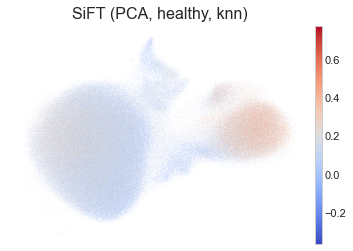

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


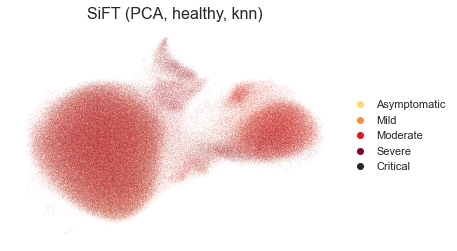

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


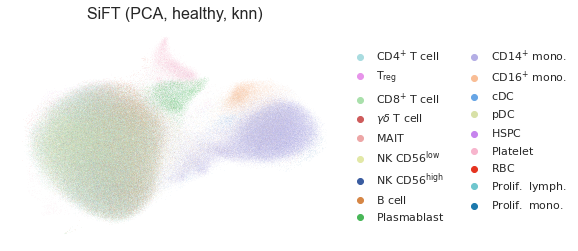

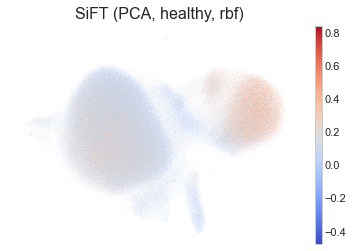

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


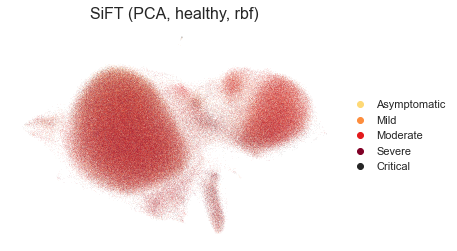

/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


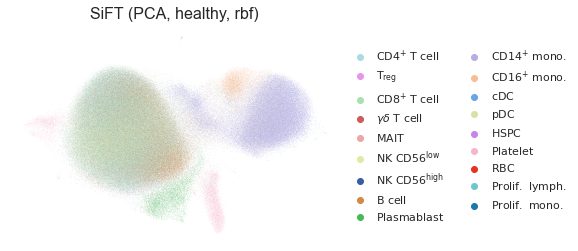

In [19]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
for key in adatas:
    for color in ["IFN_score", "Status_on_day_collection_summary", "cell_type"]:
        sc.pl.umap(adatas[key], 
                   color=color, 
                   cmap=cmap, 
                   frameon=False, 
                   show=False)
        
        plt.title(key, fontsize=16)
        plt.savefig(FIG_DIR / f"{key}_{color}_umap.png", dpi=300, bbox_inches="tight", transparent=True)
        plt.show()

### Assess scores 

In [20]:
df_scores_rbf = sc.get.obs_df(adatas["SiFT (PCA, healthy, rbf)"], ["IFN_score",
                                                          "cell_type", 
                                                          "Status_on_day_collection_summary",
                                                         ]) 

df_scores_rbf = df_scores_rbf.rename(columns={"IFN_score":"IFN response (SiFT, control, rbf)"})


In [21]:
df_scores_knn = sc.get.obs_df(adatas["SiFT (PCA, healthy, knn)"], ["IFN_score",
                                                          "cell_type", 
                                                          "Status_on_day_collection_summary",
                                                         ]) 

df_scores_knn = df_scores_knn.rename(columns={"IFN_score":"IFN response (SiFT, control, knn)"})


In [22]:
dfs = {"SiFT (PCA, healthy, rbf)": df_scores_rbf, 
       "SiFT (PCA, healthy, knn)": df_scores_knn, 
      }

In [23]:
dfs_grouped = {}
for key, df_ in dfs.items():
    dfs_grouped[key] = df_.groupby(["Status_on_day_collection_summary",  "cell_type",]).mean()
    

In [24]:
dfs_full = {}
for key, dfs_grouped_ in dfs_grouped.items():
    dfs_ = {}
    columns = adatas[key].obs["cell_type"].cat.categories
    index = adatas[key].obs["Status_on_day_collection_summary"].cat.categories
    scores = dfs_grouped_.columns
    for score in scores:
        dfs_[score] = pd.DataFrame(columns=columns, index=index, dtype="float")
        for ind in dfs_grouped_.index:
            dfs_[score].loc[ind[0], ind[1]] =  float(dfs_grouped_.loc[ind, score])
        if "Healthy" in dfs_[score].index:
            dfs_[score] = dfs_[score].reindex(["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical",])
        else:
            dfs_[score] = dfs_[score].reindex(["Asymptomatic", "Mild", "Moderate", "Severe", "Critical",])
    dfs_full[key] = dfs_

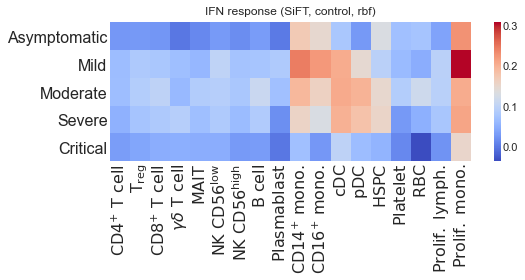

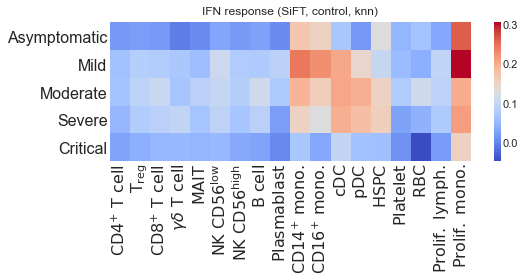

In [25]:
## Plot IFN response individual
rows = 1
cols = 1
size = 4
cmap = sns.color_palette("coolwarm", as_cmap=True)

for ki, keyi in enumerate(dfs_full):
    dfs_c = dfs_full[keyi]
    for kj, keyj in enumerate(dfs_full[keyi]):
        if "IFN response" in keyj:
            fig, axs = plt.subplots(rows, cols, figsize=(cols*(size*2), rows*size))
            sns.heatmap(dfs_c[keyj], ax=axs, cmap=cmap,)
            axs.set_title(keyj)
            axs.set_xticklabels(axs.get_xticklabels(), fontsize=16)
            axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)
            plt.tight_layout()
            plt.savefig(FIG_DIR / f"{keyj}.png", dpi=300, bbox_inches="tight", transparent=True)
            plt.show()


In [26]:
diff_ = dfs_full['SiFT (PCA, healthy, rbf)']['IFN response (SiFT, control, rbf)'] - dfs_full['SiFT (PCA, healthy, knn)']['IFN response (SiFT, control, knn)']

In [30]:
print(f"diff={np.abs(diff_.mean().mean() / dfs_full['SiFT (PCA, healthy, rbf)']['IFN response (SiFT, control, rbf)'].mean().mean() * 100):.2f}%")

diff=0.19%


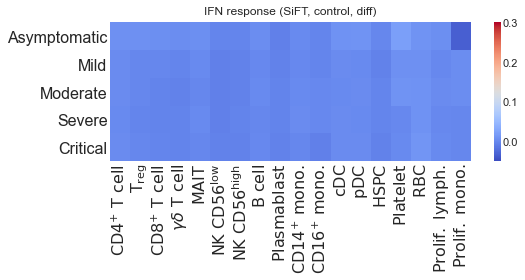

In [28]:
fig, axs = plt.subplots(rows, cols, figsize=(cols*(size*2), rows*size))
sns.heatmap(diff_, ax=axs, cmap=cmap,vmin=-0.05, vmax = 0.3)
axs.set_title("IFN response (SiFT, control, diff)")
axs.set_xticklabels(axs.get_xticklabels(), fontsize=16)
axs.set_yticklabels(axs.get_yticklabels(), fontsize=16)
plt.tight_layout()
plt.savefig(FIG_DIR / f"IFN response (SiFT, control, diff).png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## Save res

In [ ]:
adatas_paths_out = {'SiFT (PCA, healthy, rbf)': 'covid19.sift.rbf.out.h5ad'}

In [ ]:
for key_, path_ in adatas_paths_out.items():
    adatas[key_].write(DATA_DIR + path_)